# Gaussian Processes with pymc3

In [1]:
import os

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [4]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

In [75]:
from pymc3.gp.util import plot_gp_dist
import theano.tensor as tt

In [5]:
deaths = pd.read_csv("../data/us/covid/nyt_us_counties_daily.csv")

Process deaths data for LA county (FIPS 6037)

In [11]:
la = deaths.loc[deaths["fips"] == 6037]

In [52]:
days_elapsed = []
deaths = []
c_deaths = []
death_count = 0

In [53]:
counter = 0
for i, row in la.iterrows():
    death_count += int(row["deaths"])
    days_elapsed.append(counter)
    deaths.append(int(row["deaths"]))
    c_deaths.append(death_count)
    counter += 1

In [54]:
gp_diff = pd.DataFrame(data={"days_elapsed": days_elapsed, "deaths": deaths})
gp_cum = pd.DataFrame(data={"days_elapsed": days_elapsed, "deaths": c_deaths})

### Linear Prior

In [55]:
gp_in = gp_cum

In [62]:
with pm.Model() as gp_model:
    rho = pm.HalfCauchy('rho', 5)
    eta = pm.HalfCauchy('eta', 5)
    
    M = pm.gp.mean.Linear(coeffs=0)
    K = (eta**2) * pm.gp.cov.ExpQuad(1, rho) 
    
    sig = pm.HalfNormal('sig', 50)
    
    recruit_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    recruit_gp.marginal_likelihood('recruits', X=gp_in["days_elapsed"].values.reshape(-1,1), \
                           y=gp_in["deaths"].values, noise=sig)

In [57]:
with gp_model:
    gp_trace = pm.sample(1000, tune=2000, cores=2, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sig, eta, rho]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:43<00:00, 137.36draws/s]


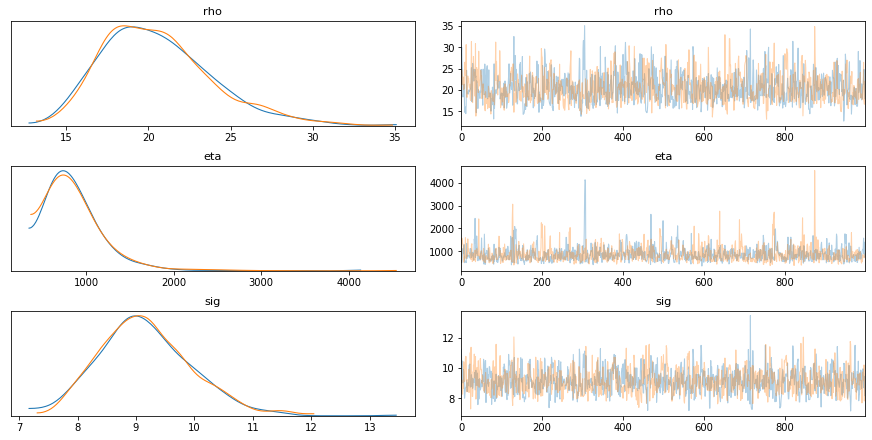

In [58]:
az.plot_trace(gp_trace, var_names=['rho', 'eta', 'sig']);

In [63]:
with gp_model:
    X_pred = np.linspace(0, 150, 150)
    predictions = recruit_gp.conditional("predictions", X_pred.reshape(-1, 1))
    gp_samples = pm.sample_posterior_predictive(gp_trace, vars=[predictions], samples=3, random_seed=42)

100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


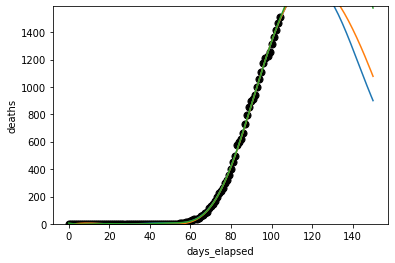

In [64]:
ax = gp_in.plot.scatter(x='days_elapsed', y='deaths', c='k', s=50)
ax.set_ylim(0, None)
for x in gp_samples['predictions']:
    ax.plot(X_pred, x);

In [65]:
with gp_model:
    gp_samples = pm.sample_posterior_predictive(gp_trace, vars=[predictions], samples=100, random_seed=42)

100%|██████████| 100/100 [00:01<00:00, 64.18it/s]


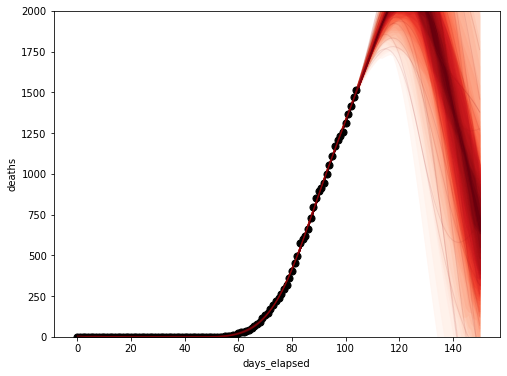

In [68]:
fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_samples['predictions'], X_pred)
gp_in.plot.scatter(x='days_elapsed', y='deaths', c='k', s=50, ax=ax)
ax.set_ylim(0, 2000);

In [69]:
with gp_model:
    pred_noise = recruit_gp.conditional("pred_noise", X_pred.reshape(-1,1), pred_noise=True)
    gp_samples = pm.sample_posterior_predictive(gp_trace, vars=[pred_noise], samples=500, random_seed=42)

100%|██████████| 500/500 [00:07<00:00, 68.63it/s]


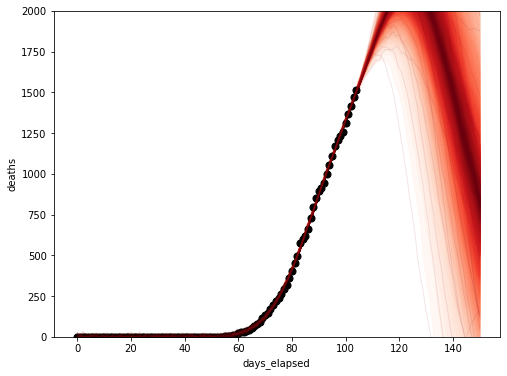

In [71]:
fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_samples['pred_noise'], X_pred)
gp_in.plot.scatter(x='days_elapsed', y='deaths', c='k', s=50, ax=ax)
ax.set_ylim(0, 2000);

## erf Prior

In [88]:
from scipy.special import erf
from scipy.optimize import curve_fit

In [89]:
def erf_curve(times, log_max, slope, center):
    max_val = 10 ** log_max
    deaths = max_val * (1 + erf(slope * (times - center)))
    return deaths

In [165]:
class erf_mean(pm.gp.mean.Mean):

    def __init__(self):
        pm.gp.mean.Mean.__init__(self)
        self.c = 0

    def __call__(self, X):
        a = tt.alloc(1.0, X.shape[0])
        return tt.fill(a, tt.erf(X[0]))

In [166]:
gp_in = gp_diff

In [202]:
with pm.Model() as gp_model:
    rho = pm.HalfCauchy('rho', 5)
    eta = pm.HalfCauchy('eta', 5)
    
    M = erf_mean()
    K = (eta**2) * pm.gp.cov.ExpQuad(1, rho) 
    
    sig = pm.HalfNormal('sig', 50)
    
    recruit_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    recruit_gp.marginal_likelihood('recruits', X=gp_in["days_elapsed"].values.reshape(-1,1), \
                           y=gp_in["deaths"].values, noise=sig)

In [203]:
with gp_model:
    X_pred = np.linspace(0, 150, 150)
    predictions = recruit_gp.conditional("predictions", X_pred.reshape(-1, 1))
    gp_samples = pm.sample_posterior_predictive(gp_trace, vars=[predictions], samples=3, random_seed=42)

100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


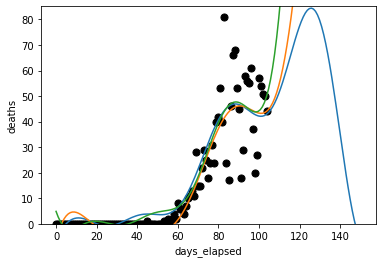

In [204]:
ax = gp_in.plot.scatter(x='days_elapsed', y='deaths', c='k', s=50)
ax.set_ylim(0, None)
for x in gp_samples['predictions']:
    ax.plot(X_pred, x);

In [196]:
help(pm.gp.cov)

Help on module pymc3.gp.cov in pymc3.gp:

NAME
    pymc3.gp.cov

CLASSES
    Covariance(builtins.object)
        Constant
        Coregion
        Gibbs
        Kron
        Linear
            Polynomial
        ScaledCov
        WarpedInput
        WhiteNoise
    Stationary(Covariance)
        Cosine
        ExpQuad
        Exponential
        Matern32
        Matern52
        Periodic
        RatQuad
    
    class Constant(Covariance)
     |  Constant(c)
     |  
     |  Constant valued covariance function.
     |  
     |  .. math::
     |  
     |     k(x, x') = c
     |  
     |  Method resolution order:
     |      Constant
     |      Covariance
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  __init__(self, c)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  diag(self, X)
     |  
     |  full(self, X, Xs=None)
     |  
     |  ----------------------------------------------------------------------
  